This is based on 'bear_Final_model' released 2020/01/23

In [ ]:
# ! pip install lightgbm

In [1]:
# Forked from excellent kernel : https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features
# From Kaggler : https://www.kaggle.com/jsaguiar
# Just added a few features so I thought I had to make release it as well...

import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import csv


In [2]:
final_df = pd.read_csv('../../../BDSE12-Group3/datasets/homecdt_ss_output/ss_fteng_appl_all_v2_20200201_balanced.csv')
#                        dtype = np.float32

In [3]:
final_df.shape

(604505, 923)

In [4]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 604505 entries, 0 to 604504
Columns: 923 entries, SK_ID_CURR to DAYS_LAST_PHONE_CHANGE_na
dtypes: float64(45), int64(878)
memory usage: 4.2 GB


In [51]:
int_colName = final_df.columns[final_df.dtypes == np.int64]
float_colName = final_df.columns[final_df.dtypes == np.float64]
int_df = final_df.loc[:, int_colName]
float_df = final_df.loc[:, float_colName]
int_df.shape, float_df.shape

((604505, 878), (604505, 45))

In [52]:
assert int_df.shape[1] + float_df.shape[1] == final_df.shape[1]
assert all(np.isfinite(int_df).all().value_counts())==True
assert all(np.isfinite(float_df).all().value_counts())==True

In [60]:
# .loc[row_indexer,col_indexer]
def reduce_mem_usage_int(props):
#     dtype_checker = all(props.dtypes is int) to be further dev.
    props.info(verbose=False)
    print("=============================================================")
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    
    props[props.columns[(props.min()>=0) & (props.max()<255)]] = \
    props.loc[:, props.columns[(props.min()>=0) & (props.max()<255)]].astype(np.uint8, copy=False)
    props.info(verbose=False)
    print("=============================================================")

    props[props.columns[(props.min()>=0) &(props.max() >= 255) & (props.max()<65535)]] = \
    props.loc[:, props.columns[(props.min()>=0) &(props.max() >= 255) & (props.max()<65535)]] \
    .astype(np.uint16, copy=False)
    props.info(verbose=False)
    print("=============================================================")

    props[props.columns[(props.min()>=0) &(props.max() >= 65535) & (props.max()<4294967295)]] = \
    props.loc[:, props.columns[(props.min()>=0) &(props.max() >= 65535) & (props.max()<4294967295)]] \
    .astype(np.uint32, copy=False)
    props.info(verbose=False)
    print("=============================================================")

#     props[props.columns[(props.min()>=0) &(props.max() >= 4294967295)]] = \
#     props.loc[:, props.columns[(props.min()>=0) &(props.max() >= 4294967295)]] \
#     .astype(np.uint64, copy=False)
#     props.info(verbose=False)
#     print("=============================================================")
    
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    
    return props

In [61]:
int_df = reduce_mem_usage_int(int_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 604505 entries, 0 to 604504
Columns: 878 entries, SK_ID_CURR to DAYS_LAST_PHONE_CHANGE_na
dtypes: int64(726), uint8(152)
memory usage: 3.4 GB
Memory usage of properties dataframe is : 3435.945442199707  MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 604505 entries, 0 to 604504
Columns: 878 entries, SK_ID_CURR to DAYS_LAST_PHONE_CHANGE_na
dtypes: int64(4), uint8(874)
memory usage: 522.3 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 604505 entries, 0 to 604504
Columns: 878 entries, SK_ID_CURR to DAYS_LAST_PHONE_CHANGE_na
dtypes: int64(4), uint8(874)
memory usage: 522.3 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 604505 entries, 0 to 604504
Columns: 878 entries, SK_ID_CURR to DAYS_LAST_PHONE_CHANGE_na
dtypes: int64(3), uint32(1), uint8(874)
memory usage: 520.0 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 604505 entries, 0 to 604504
Columns: 878 entries, SK_ID_CURR to DAYS_LAST_PHONE_CHANGE_na
dtypes: int64(3),

In [62]:
final_df = pd.concat([int_df, float_df], axis ='columns')

In [ ]:
# def reduce_mem_usage2(props):
#     props.info(verbose=False)
#     start_mem_usg = props.memory_usage().sum() / 1024**2 
#     print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    
#     props_finite = props[props.columns[np.isfinite(props).all()]]
#     props_infinite = props[props.columns[np.isfinite(props).all() == False]]
    
#     print("Processing props_finite...")
#     props_finite.info(verbose=False)
    
#     props_finite[props_finite.columns[(props_finite.min()>=0) & (props_finite.max()<255)]] = \
#     props_finite[props_finite.columns[(props_finite.min()>=0) & (props_finite.max()<255)]].astype(np.uint8, copy=False)
#     props_finite.info(verbose=False)

#     props_finite[props_finite.columns[(props_finite.min()>=0) &(props_finite.max() >= 255) & (props_finite.max()<65535)]] = \
#     props_finite[props_finite.columns[(props_finite.min()>=0) &(props_finite.max() >= 255) & (props_finite.max()<65535)]] \
#     .astype(np.uint16, copy=False)
#     props_finite.info(verbose=False)

#     props_finite[props_finite.columns[(props_finite.min()>=0) &(props_finite.max() >= 65535) & (props_finite.max()<4294967295)]] = \
#     props_finite[props_finite.columns[(props_finite.min()>=0) &(props_finite.max() >= 65535) & (props_finite.max()<4294967295)]] \
#     .astype(np.uint32, copy=False)
#     props_finite.info(verbose=False)

#     props_finite[props_finite.columns[(props_finite.min()>=0) &(props_finite.max() >= 4294967295)]] = \
#     props_finite[props_finite.columns[(props_finite.min()>=0) &(props_finite.max() >= 4294967295)]] \
#     .astype(np.uint64, copy=False)
#     props_finite.info(verbose=False)
    
    
#     print("Processing props_infinite...")
#     props_infinite.info(verbose=False)
#     props_infinite = props_infinite.astype(np.float32, copy=False)
#     props_infinite.info(verbose=False)
    
#     print("Combining props_finite & props_infinite...")
#     props = pd.concat([props_finite, props_infinite], axis ='columns')
#     print("Combine complete, new props obtained!!!")    
    
#     print("___MEMORY USAGE AFTER COMPLETION:___")
#     mem_usg = props.memory_usage().sum() / 1024**2 
#     print("Memory usage is: ",mem_usg," MB")
#     print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    
#     del props_finite
#     del props_infinite
#     gc.collect()
    
#     return props

# # if num_na_df_finite.min()>=0:
# #     if num_na_df_finite.max() < 255:
# #         props[col] = props[col].astype(np.uint8)
# #     elif num_na_df_finite.max() < 65535:
# #         props[col] = props[col].astype(np.uint16)
# #     elif num_na_df_finite.max() < 4294967295:
# #         props[col] = props[col].astype(np.uint32)
# #     else:
# #         props[col] = props[col].astype(np.uint64)

In [ ]:
# def reduce_mem_usage(props):
#     start_mem_usg = props.memory_usage().sum() / 1024**2 
#     print("Memory usage of properties dataframe is :",start_mem_usg," MB")
#     NAlist = [] # Keeps track of columns that have missing values filled in. 
#     for col in props.columns:
#         if props[col].dtype != object:  # Exclude strings
            
#             # Print current column type
#             print("******************************")
#             print("Column: ",col)
#             print("dtype before: ",props[col].dtype)
            
#             # make variables for Int, max and min
#             IsInt = False
#             mx = props[col].max()
#             mn = props[col].min()
            
#             # Integer does not support NA, therefore, NA needs to be filled
#             if not np.isfinite(props[col]).all(): 
#                 NAlist.append(col)
#                 props[col].fillna(mn-1,inplace=True)  
                   
#             # test if column can be converted to an integer
#             asint = props[col].fillna(0).astype(np.int64)
#             result = (props[col] - asint)
#             result = result.sum()
#             if result > -0.01 and result < 0.01:
#                 IsInt = True

            
#             # Make Integer/unsigned Integer datatypes
#             if IsInt:
#                 if mn >= 0:
#                     if mx < 255:
#                         props[col] = props[col].astype(np.uint8)
#                     elif mx < 65535:
#                         props[col] = props[col].astype(np.uint16)
#                     elif mx < 4294967295:
#                         props[col] = props[col].astype(np.uint32)
#                     else:
#                         props[col] = props[col].astype(np.uint64)
#                 else:
#                     if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
#                         props[col] = props[col].astype(np.int8)
#                     elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
#                         props[col] = props[col].astype(np.int16)
#                     elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
#                         props[col] = props[col].astype(np.int32)
#                     elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
#                         props[col] = props[col].astype(np.int64)    
            
#             # Make float datatypes 32 bit
#             else:
#                 props[col] = props[col].astype(np.float32)
            
#             # Print new column type
#             print("dtype after: ",props[col].dtype)
#             print("******************************")
    
#     # Print final result
#     print("___MEMORY USAGE AFTER COMPLETION:___")
#     mem_usg = props.memory_usage().sum() / 1024**2 
#     print("Memory usage is: ",mem_usg," MB")
#     print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
#     return props, NAlist

In [ ]:
# %time final_df = reduce_mem_usage2(final_df)

In [ ]:
# final_df.EXT_SOURCE_1

# LightGBM 模型

In [63]:
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

def kfold_lightgbm(df, num_folds = 5, stratified = True, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM goss. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        dtrain = lgb.Dataset(data=train_df[feats].iloc[train_idx], 
                             label=train_df['TARGET'].iloc[train_idx], 
                             free_raw_data=False, silent=True)
        dvalid = lgb.Dataset(data=train_df[feats].iloc[valid_idx], 
                             label=train_df['TARGET'].iloc[valid_idx], 
                             free_raw_data=False, silent=True)

        # LightGBM parameters found by Bayesian optimization
        params = {
            'objective': 'binary',
            'boosting_type': 'goss',
            'nthread': 4,
            'learning_rate': 0.02,  # 02,
            'num_leaves': 21, #20,33
            'tree_learner': 'voting',
            'colsample_bytree': 0.9497036,
            'subsample': 0.8715623,
            'subsample_freq': 0,
            'max_depth': 8, #8,7
            'reg_alpha': 0.041545473,
            'reg_lambda': 0.0735294,
            'min_split_gain': 0.0222415,
            'min_child_weight': 60, # 60,39
            'seed': 0,
            'verbose': 2000,
            'metric': 'auc',
#             'max_bin': 128,
#             'histogram_pool_size': 20480
#             'device' : 'gpu',
#             'gpu_platform_id': 0,
#             'gpu_device_id':0
        }
        
        clf = lgb.train(
            params=params,
            train_set=dtrain,
            num_boost_round=20000,
            valid_sets=[dtrain, dvalid],
            early_stopping_rounds=100,
            verbose_eval=2000
        )

        oof_preds[valid_idx] = clf.predict(dvalid.data)
        sub_preds += clf.predict(test_df[feats]) / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(dvalid.label, oof_preds[valid_idx])))
        del clf, dtrain, dvalid
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        sub_df = test_df[['SK_ID_CURR']].copy()
        sub_df['TARGET'] = sub_preds.astype(int)
        sub_df[['SK_ID_CURR', 'TARGET']].to_csv('../../../BDSE12-Group3/datasets/homecdt_ss_output/homecdt_submission_LGBM.csv', index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout
    plt.savefig('../../../BDSE12-Group3/datasets/homecdt_ss_output/lgbm_importances01.png')

## boosting_type：gbdt

Starting LightGBM goss. Train shape: (555761, 923), test shape: (48744, 923)
Training until validation scores don't improve for 100 rounds
[2000]	training's auc: 0.829951	valid_1's auc: 0.816523
[4000]	training's auc: 0.872684	valid_1's auc: 0.854075
[6000]	training's auc: 0.902531	valid_1's auc: 0.881212
[8000]	training's auc: 0.924192	valid_1's auc: 0.901921
[10000]	training's auc: 0.94033	valid_1's auc: 0.917869
Did not meet early stopping. Best iteration is:
[10000]	training's auc: 0.94033	valid_1's auc: 0.917869
Fold  1 AUC : 0.917869
Training until validation scores don't improve for 100 rounds
[2000]	training's auc: 0.829472	valid_1's auc: 0.820441
[4000]	training's auc: 0.872076	valid_1's auc: 0.857536
[6000]	training's auc: 0.9019	valid_1's auc: 0.884368
[8000]	training's auc: 0.923869	valid_1's auc: 0.904964
[10000]	training's auc: 0.940155	valid_1's auc: 0.920566
Did not meet early stopping. Best iteration is:
[10000]	training's auc: 0.940155	valid_1's auc: 0.920566
Fold  2 

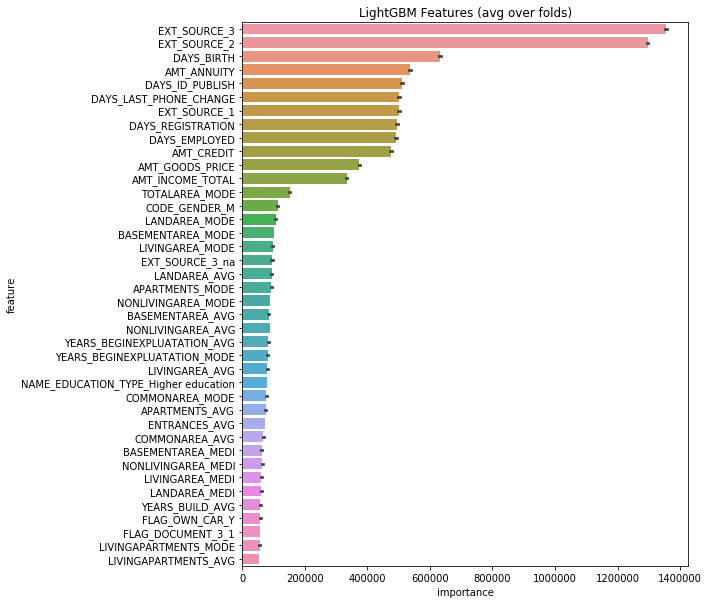

In [64]:
init_time = time.time()
kfold_lightgbm(final_df, 10)
print("Elapsed time={:5.2f} sec.".format(time.time() - init_time))

## boosting_type：goss

In [ ]:
init_time = time.time()
kfold_lightgbm(final_df,7)
print("Elapsed time={:5.2f} sec.".format(time.time() - init_time))

## boosting_type：dart

In [ ]:
init_time = time.time()
kfold_lightgbm(final_df,10)
print("Elapsed time={:5.2f} sec.".format(time.time() - init_time))

## boosting_type：rf

In [ ]:
init_time = time.time()
kfold_lightgbm(final_df,10)
print("Elapsed time={:5.2f} sec.".format(time.time() - init_time))

# XGBoost 模型

In [ ]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [ ]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pickle

In [ ]:
def kfold_xgb(df, num_folds, stratified = True, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting XGBoost. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1054)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1054)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        #if n_fold == 0: # REmove for full K-fold run
        cuda.select_device(0)
        cuda.close()
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        clf = XGBClassifier(learning_rate =0.01, 
                            n_estimators=5000, 
                            max_depth=4, 
                            min_child_weight=5,
#                             tree_method='gpu_hist',
                            subsample=0.8, 
                            colsample_bytree=0.8, 
                            objective= 'binary:logistic',
                            nthread=4,
                            scale_pos_weight=2.5,
                            seed=28,
                            reg_lambda = 1.2)
        
#         clf = pickle.load(open('test.pickle','rb'))
        
        cuda.select_device(0)
        cuda.close()
        
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 1000, early_stopping_rounds= 200)
        
        cuda.select_device(0)
        cuda.close()
        
        oof_preds[valid_idx] = clf.predict_proba(valid_x)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats])[:, 1] # / folds.n_splits # - Uncomment for K-fold 

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

        np.save("xgb_oof_preds_1", oof_preds)
        np.save("xgb_sub_preds_1", sub_preds)
        
        cuda.select_device(0)
        cuda.close()
        
    
    clf = pickle.load(open('test.pickle','rb'))
    # print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv('submission_XGBoost_GPU.csv', index= False)
    #display_importances(feature_importance_df)
    #return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('XGBoost Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('xgb_importances02.png')

In [ ]:
init_time = time.time()
kfold_xgb(final_df, 5)
print("Elapsed time={:5.2f} sec.".format(time.time() - init_time))